In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import torch
import pyrootutils
root = pyrootutils.setup_root(search_from=os.path.abspath(''), pythonpath=True, cwd=True, indicator=".project-root")
import twinturbo.src.utils.plotting as pltt

In [2]:
from twinturbo.scripts.utils import linear_interpolation, get_y_and_std_curves, get_common_x

In [3]:
group_run = "/home/users/o/oleksiyu/WORK/hyperproject/twinturbo/workspaces/ML4Jets/TRANSITv25f_group/"
doping_run = "/home/users/o/oleksiyu/WORK/hyperproject/twinturbo/workspaces/ML4Jets/TRANSITv25f_dopings"
template_from = "/home/users/o/oleksiyu/WORK/hyperproject/twinturbo/workspaces/ML4Jets/TRANSITv25f/"
one_run = "/home/users/o/oleksiyu/WORK/hyperproject/twinturbo/workspaces/ML4Jets/TRANSITv25f/"
features = ["m_j1", "del_m", "del_R", "tau21_j1", "tau21_j2",  "m_jj"]
add_latent = True

In [4]:
save_folder = "/home/users/o/oleksiyu/WORK/hyperproject/plots/ML4J_la/"
os.makedirs(save_folder, exist_ok=True)

In [5]:
#somerun ="/home/users/o/oleksiyu/WORK/hyperproject/twinturbo/workspaces/ML4Jets/TRANSITv25f_dopings/run-doping_50/run-TTS_1/"
somerun = one_run
somerun_prepr = pickle.load(open(somerun + "cathode_preprocessor.pkl", "rb"))
bins_mass_sculpting= np.linspace(3000,  4600, 40)
#bins_mass_sculpting= np.linspace(3000,  4600, 40)
dope = 3000
#dope = 50

In [6]:

file_path = somerun + f"cwola_latent/window_3100_3300__3700_3900/dope_{dope}/standard/seed_0/cwola_outputs.h5"
data = {}
with pd.HDFStore(file_path, "r") as store:
        for key in store:
            data[key[1:]] = store[key]

In [7]:
extra_bkg_path = somerun + f"cwola_latent/window_3100_3300__3700_3900/dope_{dope}/standard/seed_0/cwola_outputs_extra_bkg.h5"
extra_bkg = {}
with pd.HDFStore(extra_bkg_path, "r") as store:
        for key in store:
            extra_bkg[key[1:]] = store[key]
extra_bkg=extra_bkg["df"]

In [8]:
print(len(data["df"]))
bkg = data["df"][data["df"]["is_signal"]!=1]
extra_bkg = extra_bkg[(extra_bkg['m_jj'] <= 3000) | (extra_bkg['m_jj'] >= 4600)]
print(len(bkg))

380537
378265


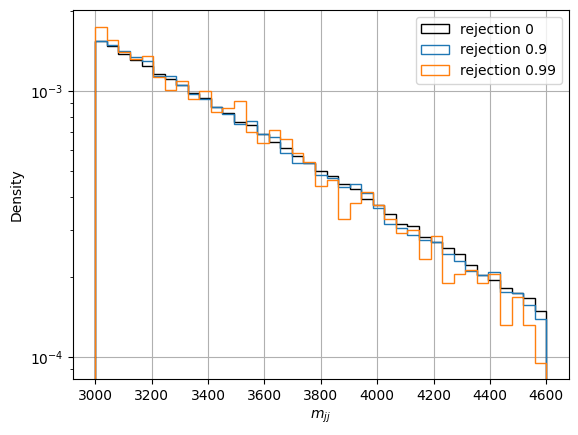

In [9]:
rej_cuts = [0, 0.9, 0.99]
scores = pd.concat([bkg["preds"], extra_bkg["preds"]])
masses = pd.concat([bkg["m_jj"], extra_bkg["m_jj"]])
sorted_indices = np.argsort(scores)[::-1]
sorted_masses = np.array(masses)[sorted_indices]
sorted_scores = np.array(scores)[sorted_indices]
for i, rej_cut in enumerate(rej_cuts):
    cut_index = -int(len(sorted_scores) * rej_cut)
    if rej_cut == 0:
        plt.hist(sorted_masses, bins=bins_mass_sculpting, label=f"rejection {rej_cut}", histtype='step', density=True, color="black")
    else:
        plt.hist(sorted_masses[:cut_index], bins=bins_mass_sculpting, label=f"rejection {rej_cut}", histtype='step', density=True)
plt.yscale("log")
plt.legend()
plt.grid()
#plt.axvline(3000, color="grey", linestyle="--")
#plt.axvline(4600, color="grey", linestyle="--")
plt.xlabel("$m_{jj}$")
plt.ylabel("Density")
plt.savefig(save_folder+"mass_sculpting_latent.png", bbox_inches='tight', dpi=300)

In [10]:
file_path = somerun + f"cwola/window_3100_3300__3700_3900/dope_{dope}/standard/seed_0/cwola_outputs.h5"
data = {}
with pd.HDFStore(file_path, "r") as store:
        for key in store:
            data[key[1:]] = store[key]
extra_bkg_path = somerun + f"cwola/window_3100_3300__3700_3900/dope_{dope}/standard/seed_0/cwola_outputs_extra_bkg.h5"
extra_bkg = {}
with pd.HDFStore(extra_bkg_path, "r") as store:
        for key in store:
            extra_bkg[key[1:]] = store[key]
extra_bkg_cwola=extra_bkg["df"]
bkg_cwola = data["df"][data["df"]["is_signal"]==0]
#extra_bkg = extra_bkg[(extra_bkg['m_jj'] <= 3000) | (extra_bkg['m_jj'] >= 4600)]
bkg_cwola.reset_index(drop=True, inplace=True)
extra_bkg_cwola.reset_index(drop=True, inplace=True)
print()


In [11]:
bkg_pr=somerun_prepr.inverse_transform(torch.Tensor(bkg_cwola[features].values)).numpy()
extra_bkg_pr=somerun_prepr.inverse_transform(torch.Tensor(extra_bkg_cwola[features].values)).numpy()

In [12]:
bkg_pr = pd.DataFrame(bkg_pr, columns=features)
extra_bkg_pr = pd.DataFrame(extra_bkg_pr, columns=features)

In [13]:
bkg_pr["preds"] = bkg_cwola["preds"]
extra_bkg_pr["preds"] = extra_bkg_cwola["preds"]

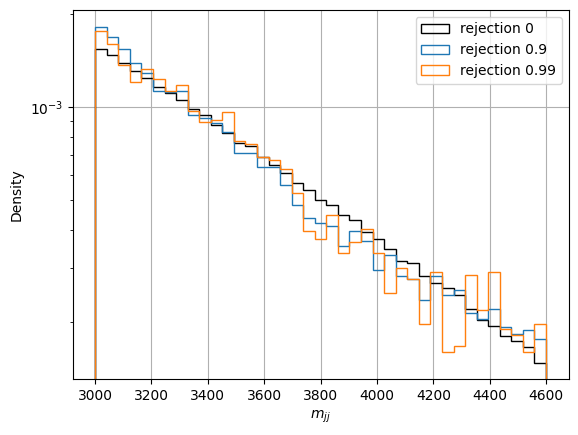

In [14]:
rej_cuts = [0, 0.9, 0.99]
scores = pd.concat([bkg_pr["preds"], extra_bkg_pr["preds"]])
masses = pd.concat([bkg_pr["m_jj"], extra_bkg_pr["m_jj"]])
sorted_indices = np.argsort(scores)[::-1]
sorted_masses = np.array(masses)[sorted_indices]
sorted_scores = np.array(scores)[sorted_indices]

for i, rej_cut in enumerate(rej_cuts):
    cut_index = -int(len(sorted_scores) * rej_cut)
    if rej_cut == 0:
        plt.hist(sorted_masses, bins=bins_mass_sculpting, label=f"rejection {rej_cut}", histtype='step', density=True, color="black")
    else:
        plt.hist(sorted_masses[:cut_index], bins=bins_mass_sculpting, label=f"rejection {rej_cut}", histtype='step', density=True)
plt.yscale("log")
plt.legend()
plt.grid()
plt.xlabel("$m_{jj}$")
plt.ylabel("Density")
plt.savefig(save_folder+"mass_sculpting_template.png", bbox_inches='tight', dpi=300)

In [15]:
import os
import re

def find_execution_times(root_directory):
    execution_times = []
    # Traverse directory tree
    for dirpath, _, filenames in os.walk(root_directory):
        for filename in filenames:
            if filename == "execution_time.txt":
                # Construct full file path
                file_path = os.path.join(dirpath, filename)
                with open(file_path, 'r') as file:
                    line = file.readline().strip()
                    # Extract time using regex
                    match = re.search(r"Execution Time:\s*([\d.]+)\s*seconds", line)
                    if match:
                        execution_time = float(match.group(1))
                        execution_times.append(execution_time)
    return execution_times

execution_times = np.array(find_execution_times(group_run))

In [16]:
print(execution_times)
print(np.mean(execution_times)/60)

[737.9  729.33 667.68 699.8  800.8  678.39 684.33 623.93 583.57 756.16
 764.21 664.75 777.07 669.81 727.73 737.11 753.76 676.26 740.85 595.98
 586.95 660.48 653.96 604.81 657.36 602.47 729.31 655.65 637.3  706.71]
11.424677777777779


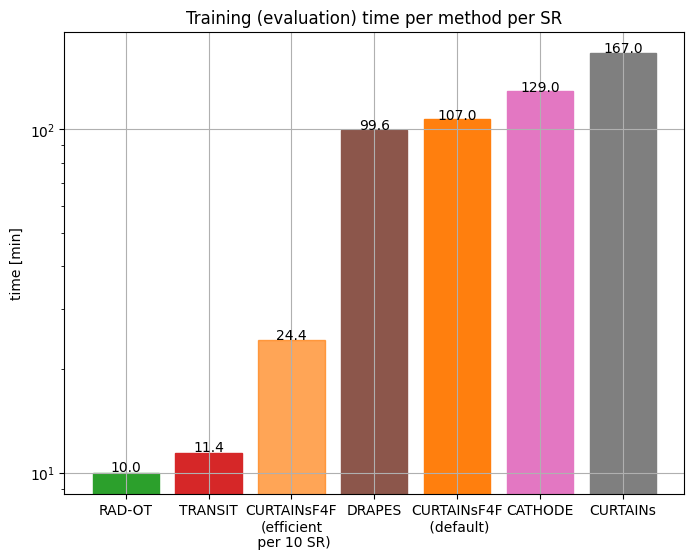

In [17]:
# Make the speed plot
values = [10, np.mean(execution_times)/60, 244/10, 1.66*60, 107, 129, 167]
methods = ["RAD-OT", "TRANSIT", "CURTAINsF4F\n(efficient\n per 10 SR)", "DRAPES",  "CURTAINsF4F\n (default)", "CATHODE",  "CURTAINs"]

# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(methods, values)
for i, value in enumerate(values):
    plt.text(i, value + 0.1, f"{value:.1f}", ha='center')
# Assign each bar a different color
color_is = [2, 3, 1, 5, 1, 6, 7]
for i, bar in enumerate(bars):
    bar.set_color(plt.cm.tab10(color_is[i]))  # Using a colormap for varied colors
    if i==2:
        bar.set_alpha(0.7)  # Set transparency

# Labels and title
plt.ylabel("time [min]")
plt.yscale("log")
plt.grid()
#plt.xlabel("Methods")
plt.title("Training (evaluation) time per method per SR")

# Show plot
plt.savefig(save_folder + "speed_plot.png")

In [21]:
df = pd.read_hdf("/home/users/o/oleksiyu/scratch/DATA/LHCO/events_anomalydetection_v2.features_prepCURTAINS.h5")

In [22]:
df_sig = df[df["is_signal"]==True]
df_bkg = df[df["is_signal"]==False]
df_bkg_sbsr = df_bkg[df_bkg["m_jj"]>3000]
df_bkg_sbsr = df_bkg_sbsr[df_bkg_sbsr["m_jj"]<4600]
df_bkg_sb = df_bkg_sbsr[(df['m_jj'] <= 3300) | (df['m_jj'] >= 3700)]
df_bkg_sr = df_bkg[df_bkg["m_jj"]>3300]
df_bkg_sr = df_bkg_sr[df_bkg_sr["m_jj"]<3700]

/tmp/ipykernel_2244785/345145853.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_bkg_sb = df_bkg_sbsr[(df['m_jj'] <= 3300) | (df['m_jj'] >= 3700)]


In [23]:
df_bkg_sr

,is_signal,px_j1,py_j1,pz_j1,m_j1,pt_j1,phi_j1,eta_j1,p_j1,e_j1,...,m_jj,del_m,tau21_j1,tau32_j1,tau21_j2,tau32_j2,m_n,del_R,del_phi,del_eta
0,False,-1467.239990,611.502014,511.101990,38.896000,1589.568464,2.746713,0.316238,1669.716487,1670.169466,...,3307.219387,198.997997,0.583317,0.880918,0.263237,0.797590,3030.429390,3.146662,3.088470,0.602360
53,False,1196.349976,561.049988,-64.198502,146.166000,1321.374418,0.438515,-0.048566,1322.933029,1330.983208,...,3563.933001,3.876007,0.593233,0.792424,0.747219,0.852569,3267.724994,3.487259,3.047086,1.695949
60,False,437.184998,1360.010010,-1364.130005,185.050995,1428.550996,1.259772,-0.849124,1975.249002,1983.898306,...,3336.961354,90.123993,0.674910,0.603939,0.744809,0.734496,2876.735372,3.166353,2.933906,1.190792
68,False,-1258.699951,1012.309998,942.002014,181.179993,1615.269977,2.464265,0.554353,1869.883658,1878.640754,...,3472.849614,97.941010,0.629373,0.650525,0.462002,0.779867,3012.548619,2.965060,2.826204,0.896747
81,False,807.778992,-1086.300049,-2300.449951,67.803001,1353.718839,-0.931400,-1.300494,2669.199257,2670.060284,...,3358.943097,171.510994,0.584220,0.588408,0.559757,0.679305,3051.826101,3.491847,3.139809,1.527939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049858,False,-14.563800,-1120.099976,-652.872986,211.809998,1120.194653,-1.583798,-0.554038,1296.564381,1313.751373,...,3462.368211,8.022995,0.467944,0.790485,0.465897,0.788281,3030.725220,3.527699,3.100661,1.682427
1049863,False,727.786011,926.698975,1359.760010,78.853798,1178.322310,0.905050,0.986175,1799.275063,1801.002130,...,3459.228117,181.539207,0.474347,0.751596,0.523599,0.752784,3119.981314,3.513321,3.125202,1.605159
1049875,False,59.328201,-1442.920044,611.273987,158.774002,1444.139221,-1.529703,0.411562,1568.181742,1576.198959,...,3601.049364,58.750000,0.595861,0.776109,0.533434,0.661217,3224.751360,3.403007,3.140525,1.310558
1049878,False,-1133.000000,533.672974,-527.125977,21.905600,1252.396041,2.701391,-0.409364,1358.807432,1358.983993,...,3427.125197,601.750406,0.790399,0.799534,0.308047,0.516920,2781.563591,3.514344,3.141545,1.575216


/tmp/ipykernel_2244785/3705273667.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  events = df_bkg_sbsr[(df_bkg["m_jj"]>bins[i]) & (df_bkg["m_jj"]<bins[i+1])]
/tmp/ipykernel_2244785/3705273667.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  events = df_bkg_sbsr[(df_bkg["m_jj"]>bins[i]) & (df_bkg["m_jj"]<bins[i+1])]
/tmp/ipykernel_2244785/3705273667.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  events = df_bkg_sbsr[(df_bkg["m_jj"]>bins[i]) & (df_bkg["m_jj"]<bins[i+1])]
/tmp/ipykernel_2244785/3705273667.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  events = df_bkg_sbsr[(df_bkg["m_jj"]>bins[i]) & (df_bkg["m_jj"]<bins[i+1])]
/tmp/ipykernel_2244785/3705273667.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  events = df_bkg_sbsr[(df_bkg["m_jj"]>bins[i]) & (df_bkg["m_jj"]<bins[i+1])]
/tmp/ipykernel_2244785/3705273

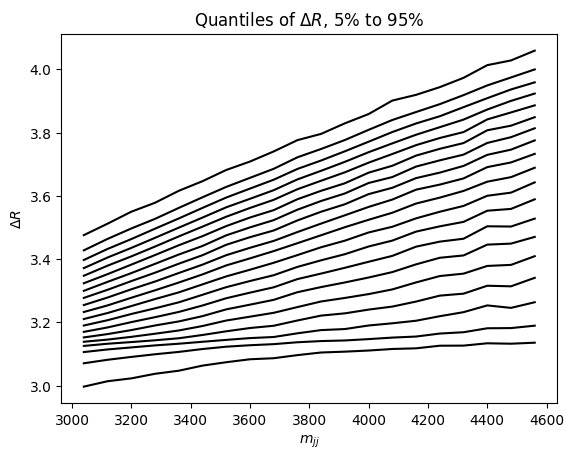

In [24]:
def get_quantile(n_bins=20, variable = "del_R", q=0.75):
    bins = np.linspace(3000, 4600, n_bins+1)
    quantile_line = []
    for i in range(n_bins):
        events = df_bkg_sbsr[(df_bkg["m_jj"]>bins[i]) & (df_bkg["m_jj"]<bins[i+1])]
        quantile_line.append(events[variable].quantile(q))
    return bins, quantile_line

for q in [0.05*i for i in range(1, 20)]:
    bins, quantile_line = get_quantile(n_bins=20, variable = "del_R", q=q)
    #plt.step(bins[:-1]/2+bins[1:]/2, quantile_line, where='mid', color='black')
    plt.plot(bins[:-1]/2+bins[1:]/2, quantile_line, color='black')
    
plt.xlabel("$m_{jj}$")
plt.ylabel("$\Delta R$")
plt.title("Quantiles of $\Delta R$, 5% to 95%")
plt.savefig(save_folder+"quantiles_del_R.png", bbox_inches='tight', dpi=300)

/tmp/ipykernel_2244785/4032396452.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  events = df_bkg_sbsr[(df_bkg["m_jj"]>bins[i]) & (df_bkg["m_jj"]<bins[i+1])]
/tmp/ipykernel_2244785/4032396452.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  events = df_bkg_sbsr[(df_bkg["m_jj"]>bins[i]) & (df_bkg["m_jj"]<bins[i+1])]
/tmp/ipykernel_2244785/4032396452.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  events = df_bkg_sbsr[(df_bkg["m_jj"]>bins[i]) & (df_bkg["m_jj"]<bins[i+1])]
/tmp/ipykernel_2244785/4032396452.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  events = df_bkg_sbsr[(df_bkg["m_jj"]>bins[i]) & (df_bkg["m_jj"]<bins[i+1])]
/tmp/ipykernel_2244785/4032396452.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  events = df_bkg_sbsr[(df_bkg["m_jj"]>bins[i]) & (df_bkg["m_jj"]<bins[i+1])]
/tmp/ipykernel_2244785/4032396

/tmp/ipykernel_2244785/4032396452.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  events = df_bkg_sbsr[(df_bkg["m_jj"]>bins[i]) & (df_bkg["m_jj"]<bins[i+1])]
/tmp/ipykernel_2244785/4032396452.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  events = df_bkg_sbsr[(df_bkg["m_jj"]>bins[i]) & (df_bkg["m_jj"]<bins[i+1])]
/tmp/ipykernel_2244785/4032396452.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  events = df_bkg_sbsr[(df_bkg["m_jj"]>bins[i]) & (df_bkg["m_jj"]<bins[i+1])]
/tmp/ipykernel_2244785/4032396452.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  events = df_bkg_sbsr[(df_bkg["m_jj"]>bins[i]) & (df_bkg["m_jj"]<bins[i+1])]
/tmp/ipykernel_2244785/4032396452.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  events = df_bkg_sbsr[(df_bkg["m_jj"]>bins[i]) & (df_bkg["m_jj"]<bins[i+1])]
/tmp/ipykernel_2244785/4032396

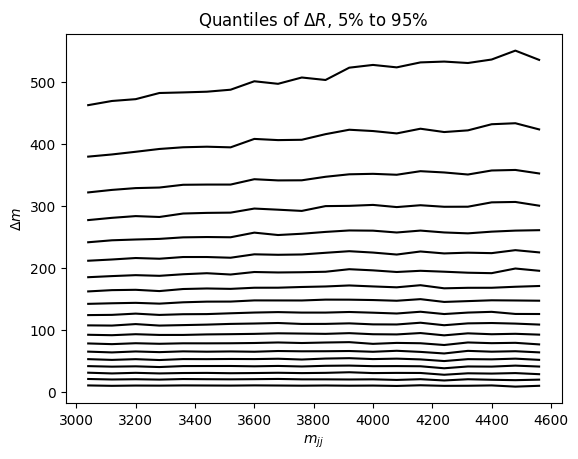

In [25]:
def get_quantile(n_bins=20, variable = "del_m", q=0.75):
    bins = np.linspace(3000, 4600, n_bins+1)
    quantile_line = []
    for i in range(n_bins):
        events = df_bkg_sbsr[(df_bkg["m_jj"]>bins[i]) & (df_bkg["m_jj"]<bins[i+1])]
        quantile_line.append(events[variable].quantile(q))
    return bins, quantile_line

for q in [0.05*i for i in range(1, 20)]:
    bins, quantile_line = get_quantile(n_bins=20, variable = "del_m", q=q)
    #plt.step(bins[:-1]/2+bins[1:]/2, quantile_line, where='mid', color='black')
    plt.plot(bins[:-1]/2+bins[1:]/2, quantile_line, color='black')
    
plt.xlabel("$m_{jj}$")
plt.ylabel("$\Delta m$")
plt.title("Quantiles of $\Delta R$, 5% to 95%")
plt.savefig(save_folder+"quantiles_del_m.png", bbox_inches='tight', dpi=300)

In [26]:
# load template and reverse transform it:
template = pd.read_hdf(one_run + "template/outputs/template_sample.h5")
template_numpy=template[features].to_numpy()


In [27]:
processor = pickle.load(open("/home/users/o/oleksiyu/WORK/hyperproject/twinturbo/workspaces/ML4Jets/TRANSITv10f_group/run-TTS_1/cathode_preprocessor.pkl", "rb"))

In [28]:
template_numpy_tr=processor.inverse_transform(torch.Tensor(template_numpy))

In [29]:
template_tr = pd.DataFrame(template_numpy_tr, columns=features)

/tmp/ipykernel_2244785/3104886256.py:61: RuntimeWarning: invalid value encountered in divide
  diff = (counts[column][j] - counts[column][0])/np.sqrt(counts[column][0])
/tmp/ipykernel_2244785/3104886256.py:61: RuntimeWarning: divide by zero encountered in divide
  diff = (counts[column][j] - counts[column][0])/np.sqrt(counts[column][0])


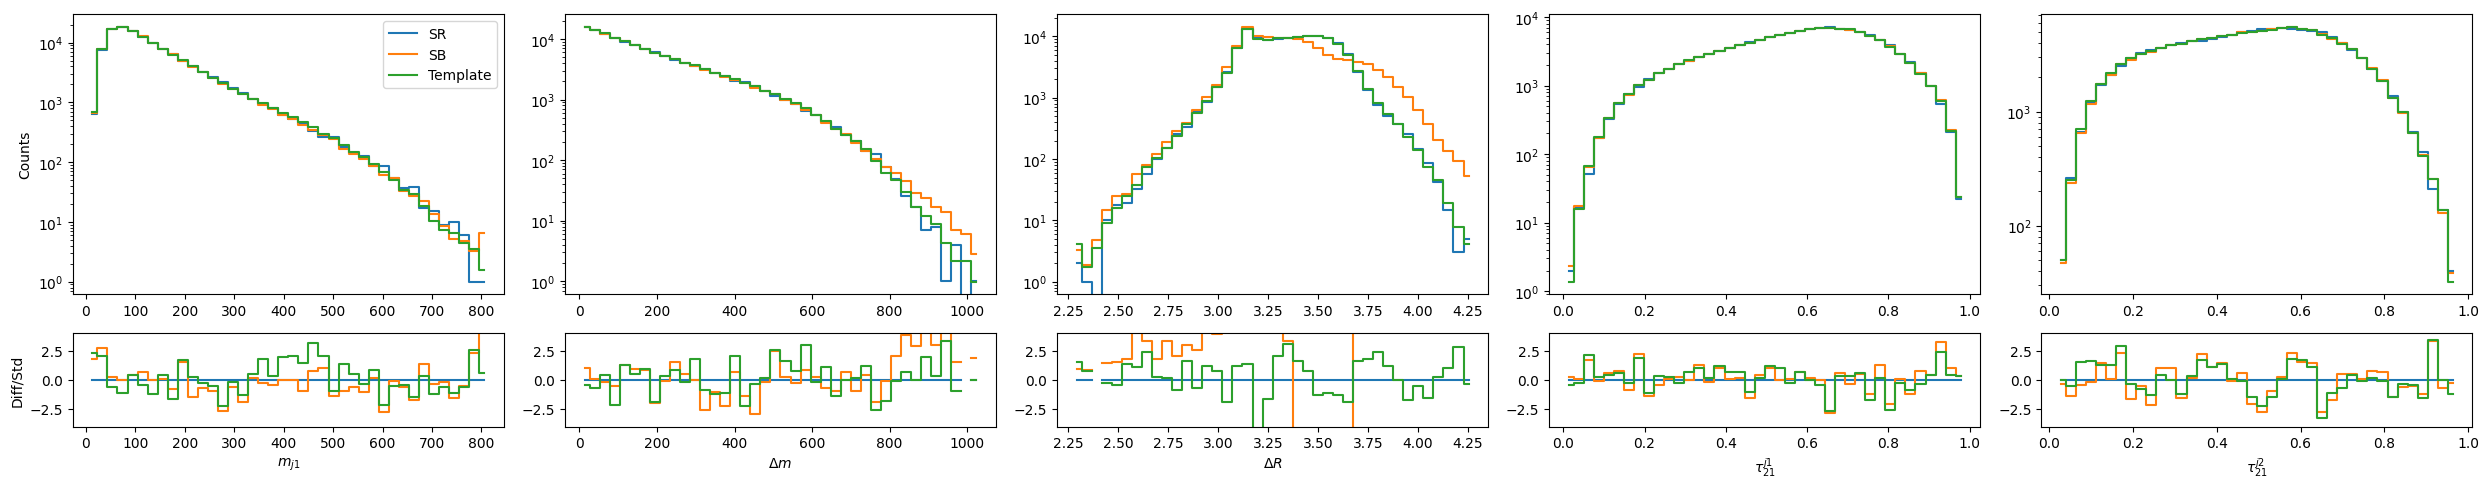

<Figure size 640x480 with 0 Axes>

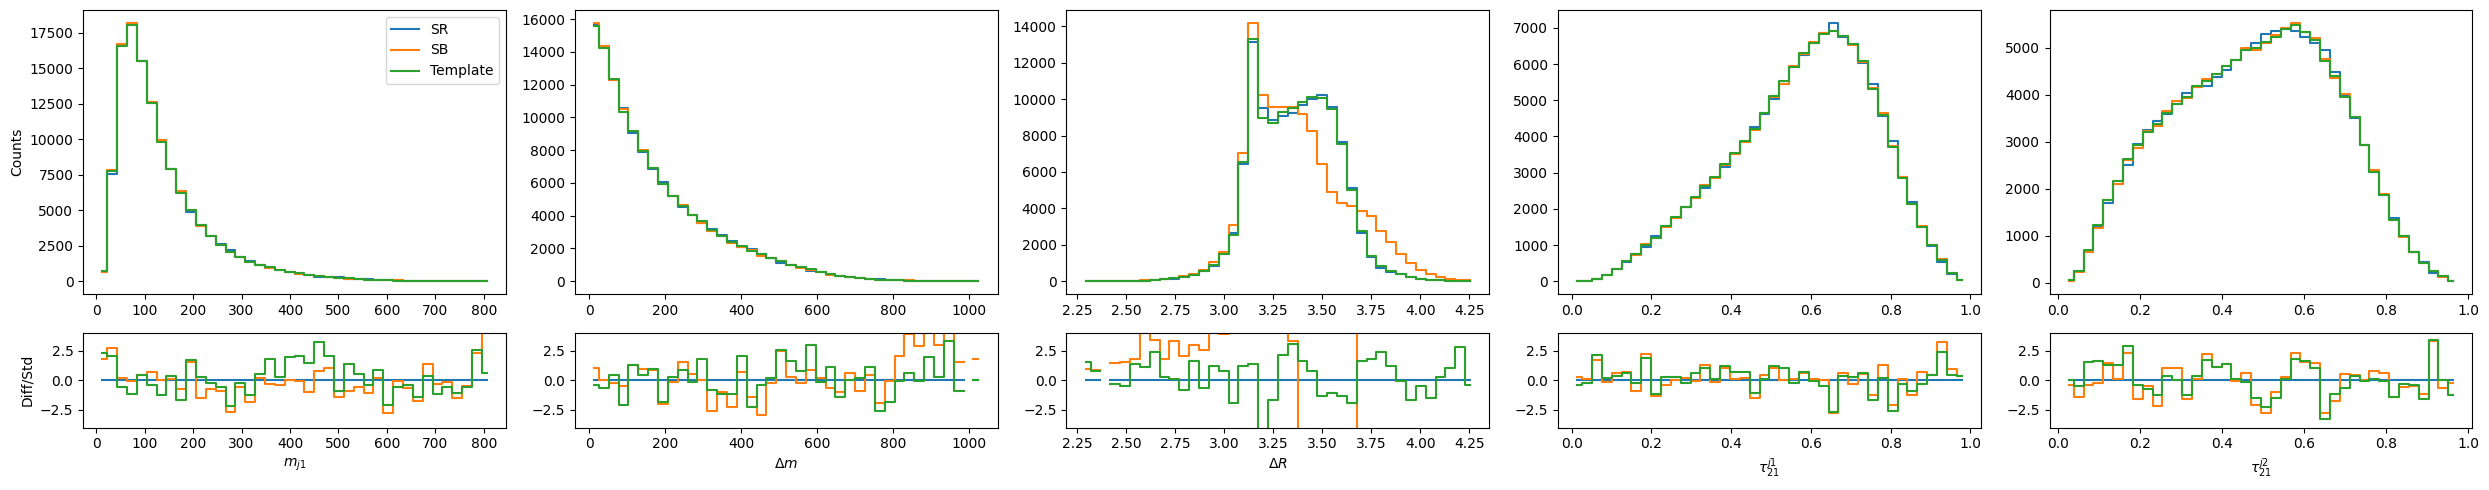

In [30]:
def plot_histograms(databases, 
                    columns, 
                    log_scale=False, 
                    plot_difs=True, 
                    labels = ["SR", "SB", "Template"],
                    normalise="first_sounts",
                    scale=5):
    """
    Function to plot histograms of selected columns from multiple databases.
    
    Parameters:
    databases: list of pandas DataFrames (databases containing same columns)
    columns: list of columns (column names to plot)
    
    Returns:
    Displays histograms of each column in a single row.
    """
    # Number of columns to plot
    num_columns = len(columns)
    
    # Create a figure with subplots, one for each column in one row
    if plot_difs:
        fig, axes = plt.subplots(2, num_columns, figsize=(scale * num_columns, scale), gridspec_kw={'height_ratios': [3, 1]}) 
    else:
        fig, axes = plt.subplots(1, num_columns, figsize=(scale * num_columns, scale))
    

    # Loop over the columns
    counts={}
    for i, column in enumerate(columns):
        # Merge the same column from all databases into one for easy plotting
        counts[column] = []
        if plot_difs:
            plt.sca(axes[0][i])
        else:
            plt.sca(axes[i])
        bins = 40
        # Plot the histogram in the corresponding subplot
        
        for j, db in enumerate(databases):
            if normalise=="none":
                counts_temp, bins, _ = plt.hist(db[column], bins=bins, histtype='step', density=True, label=labels[j])
            else:
                counts_temp, bins =np.histogram(db[column], bins=bins)
                plt.step(bins[:-1]/2+bins[1:]/2, counts_temp*len(databases[0])/len(databases[j]), where='mid', label=labels[j])
            counts[column].append(counts_temp*len(databases[0])/len(databases[j]))
            if log_scale:
                plt.yscale('log')
        if i == 0:
                plt.legend()
        if i == 0:
            plt.ylabel('Counts')
        # # plot differecwsa on bottom subplots
        if plot_difs:
            plt.sca(axes[1][i])
            if i == 0:
                plt.ylabel('Diff/Std')
                
            diffs = []
            for j in range(len(databases)):
                diff = (counts[column][j] - counts[column][0])/np.sqrt(counts[column][0])
                diffs.append(diff)
                plt.step(bins[:-1]/2+bins[1:]/2, diff, where='mid')
                plt.ylim(-4, 4)
            
        if column == "m_j1":
            column_name = "$m_{j1}$"
        elif column == "del_m":
            column_name = "$\Delta m$"
        elif column == "del_R":
            column_name = "$\Delta R$"
        elif column == "tau21_j1":
            column_name = "$\\tau_{21}^{j1}$"
        elif column == "tau21_j2":
            column_name = "$\\tau_{21}^{j2}$"
        if column == "m_jj":
            column_name = "$m_{jj}$"
        plt.xlabel(column_name)
    # Adjust layout to prevent overlap
    plt.tight_layout()
    

plot_histograms([df_bkg_sr, df_bkg_sb, template_tr], features[:-1], log_scale=True)
plt.savefig(save_folder+"template_quality_log.png", bbox_inches='tight', dpi=300)
plt.figure()
plot_histograms([df_bkg_sr, df_bkg_sb, template_tr], features[:-1], log_scale=False)
plt.savefig(save_folder+"template_quality.png", bbox_inches='tight', dpi=300)



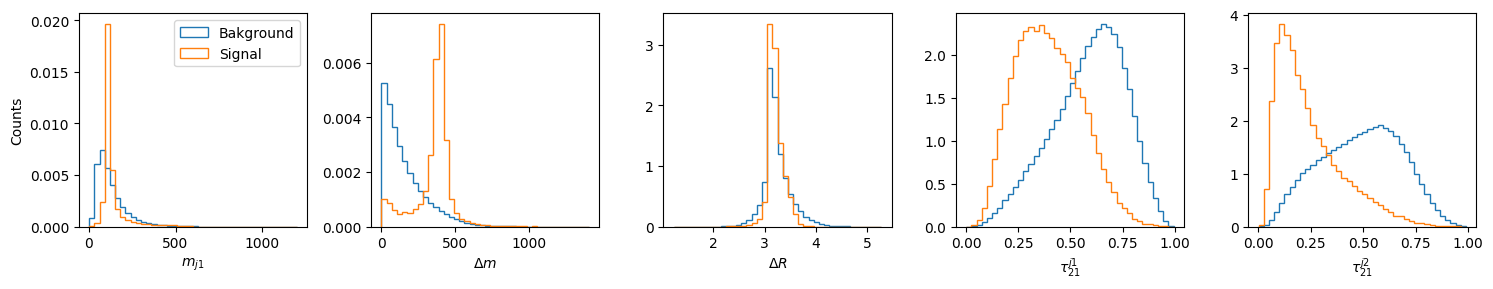

In [31]:
plot_histograms([df_bkg, df_sig], features[:-1], log_scale=False, labels=["Bakground", "Signal"], plot_difs=False, normalise="none", scale=3)
plt.savefig(save_folder+"LHCO.png", bbox_inches='tight', dpi=300)

In [32]:
N_EVENTS_SR = len(df_bkg_sr["m_jj"].values)
print(N_EVENTS_SR)

121339


In [33]:
# load my curves
my_curver_rej = np.load(group_run+"plots/compare/TwinTurbo_rejection_v_TPR_comb_seeds_CWOLA.npy")
my_curve_sic = np.load(group_run+"plots/compare/TwinTurbo_SI_v_rej_comb_seeds_CWOLA.npy")
my_curve_roc_closure = np.load(group_run+"plots/compare/TwinTurbo_ROC_closure_comb_seeds_CWOLA.npy")

laTRANSIT_curver_rej = np.load(group_run+"plots/compare/TwinTurboLatent_rejection_v_TPR_comb_seeds_CWOLA.npy")
laTRANSIT_curve_sic = np.load(group_run+"plots/compare/TwinTurboLatent_SI_v_rej_comb_seeds_CWOLA.npy")
laTRANSIT_curve_roc_closure = np.load(group_run+"plots/compare/TwinTurboLatent_ROC_closure_comb_seeds_CWOLA.npy")
#print(my_curver_rej)

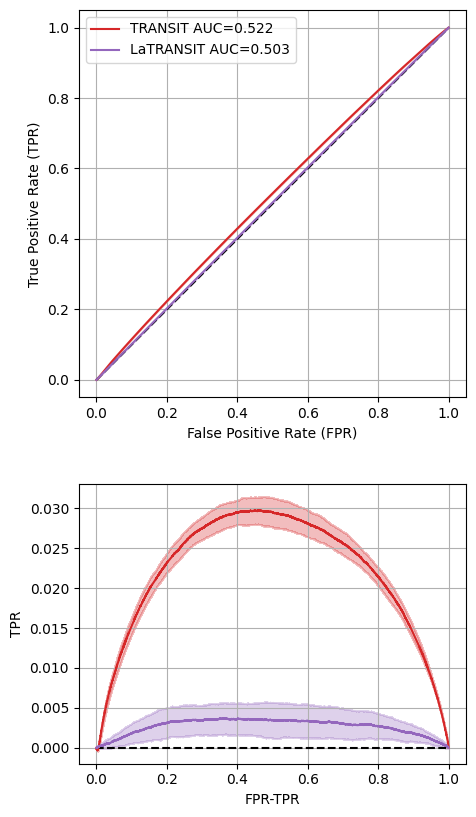

In [34]:
from sklearn.metrics import auc, roc_curve
fig, axes = plt.subplots(2, 1, figsize=(5, 10), gridspec_kw={'height_ratios': [3, 2]})
plt.sca(axes[0])
my_auc_score = auc(my_curve_roc_closure[0], my_curve_roc_closure[1])
laTRANSIT_auc_score = auc(laTRANSIT_curve_roc_closure[0], laTRANSIT_curve_roc_closure[1])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.grid(which='major')
plt.gca().set_aspect('equal')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.plot(my_curve_roc_closure[0], my_curve_roc_closure[1], label=f"TRANSIT AUC={my_auc_score:.3f}", color="C3")
plt.fill_between(my_curve_roc_closure[0], my_curve_roc_closure[1]-my_curve_roc_closure[2], my_curve_roc_closure[1]+my_curve_roc_closure[2], alpha=0.3, color="C3")
if add_latent:
    plt.plot(laTRANSIT_curve_roc_closure[0], laTRANSIT_curve_roc_closure[1], label=f"LaTRANSIT AUC={laTRANSIT_auc_score:.3f}", color="C4")
    plt.fill_between(laTRANSIT_curve_roc_closure[0], laTRANSIT_curve_roc_closure[1]-laTRANSIT_curve_roc_closure[2], laTRANSIT_curve_roc_closure[1]+laTRANSIT_curve_roc_closure[2], alpha=0.3, color="C4")
    plt.legend()

plt.sca(axes[1])
plt.plot([0, 1], [0, 0], color='black', linestyle='--')
plt.plot(my_curve_roc_closure[0], my_curve_roc_closure[1]-my_curve_roc_closure[0], color="C3")
plt.fill_between(my_curve_roc_closure[0], my_curve_roc_closure[1]-my_curve_roc_closure[0]-my_curve_roc_closure[2], my_curve_roc_closure[1]-my_curve_roc_closure[0]+my_curve_roc_closure[2], alpha=0.3, color="C3")
if add_latent:
    plt.plot(laTRANSIT_curve_roc_closure[0], laTRANSIT_curve_roc_closure[1]-laTRANSIT_curve_roc_closure[0], color="C4")
    plt.fill_between(laTRANSIT_curve_roc_closure[0], laTRANSIT_curve_roc_closure[1]-laTRANSIT_curve_roc_closure[0]-laTRANSIT_curve_roc_closure[2], laTRANSIT_curve_roc_closure[1]-laTRANSIT_curve_roc_closure[0]+laTRANSIT_curve_roc_closure[2], alpha=0.3, color="C4")
plt.xlabel('FPR-TPR')
plt.ylabel('TPR')
plt.grid()

In [35]:
# load CURTAINSF4F
run=8
SI_rejs = []
for seed in range(5):
    SI_curve_file = f"/home/users/o/oleksiyu/WORK/hyperproject/lit/curtains/run_{run}/seed_{seed}/SI_v_rej.npy"
    SI_rej = np.load(SI_curve_file)
    SI_rej[0] = np.flip(SI_rej[0])
    SI_rej[1] = np.flip(SI_rej[1])
    SI_rejs += [SI_rej]
common_x = get_common_x(SI_rejs)
print(common_x)
y, y_std = get_y_and_std_curves(SI_rejs, common_x)
curtains_sic = np.concatenate([common_x.reshape(1, len(common_x)), y.reshape(1, len(common_x)), y_std.reshape(1, len(common_x))], axis=0)

#npy_file =  "/home/users/o/oleksiyu/WORK/hyperproject/lit/curtains/run_8/seed_0/rejection_v_TPR.npy"
#curtains_rej = np.load(npy_file)
#npy_file =  "/home/users/o/oleksiyu/WORK/hyperproject/lit/curtains/run_8/seed_0/SI_v_rej.npy"


[1.00000000e+00 1.00002472e+00 1.00004945e+00 ... 4.04463333e+04
 6.06695000e+04 1.21339000e+05]


In [36]:
run=8
rej_rejs = []
for seed in range(5):
    rej_curve_file = f"/home/users/o/oleksiyu/WORK/hyperproject/lit/curtains/run_{run}/seed_{seed}/rejection_v_TPR.npy"
    rej_rej = np.load(rej_curve_file)
    rej_rejs += [rej_rej]
common_x1 = get_common_x(rej_rejs)
print(common_x1)
y1, y_std1 = get_y_and_std_curves(rej_rejs, common_x1)
curtains_rej = np.concatenate([common_x1.reshape(1, len(common_x1)), y1.reshape(1, len(common_x1)), y_std1.reshape(1, len(common_x1))], axis=0)


[0.00000000e+00 1.10406960e-05 1.76099101e-02 ... 9.99977919e-01
 9.99988959e-01 1.00000000e+00]


/home/users/o/oleksiyu/WORK/hyperproject/twinturbo/scripts/utils.py:24: RuntimeWarning: invalid value encountered in scalar subtract
  x_news.append(y0 + (y1 - y0) * (x_n - x0) / (x1 - x0))
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [37]:
# Load supervised 
csv_file_path = '/srv/beegfs/scratch/groups/rodem/oliws/radot_rej_3000.csv'
radot1 = pd.read_csv(csv_file_path)
csv_file_path = '/srv/beegfs/scratch/groups/rodem/oliws/radot_tpr_3000.csv'
radot2 = pd.read_csv(csv_file_path)
#print(radot1.head())

In [38]:
# Load Idealised 
csv_file_path = '/srv/beegfs/scratch/groups/rodem/oliws/for_ivan/rej_vs_tpr_3000_idealised.csv'
ideal_rej = pd.read_csv(csv_file_path)
csv_file_path = '/srv/beegfs/scratch/groups/rodem/oliws/for_ivan/sic_vs_reg_3000_idealised.csv'
ideal_sic = pd.read_csv(csv_file_path)

In [39]:
# load RADOT curves
csv_file_path = '/srv/beegfs/scratch/groups/rodem/oliws/for_ivan/rej_vs_tpr_3000_supervised.csv'
super_rej = pd.read_csv(csv_file_path)
csv_file_path = '/srv/beegfs/scratch/groups/rodem/oliws/for_ivan/sic_vs_reg_3000_supervised.csv'
super_sic = pd.read_csv(csv_file_path)
#print(radot1.head())

In [40]:
from scipy.interpolate import interp1d
def filter_finite_values(x):
    return x[np.isfinite(x)]

In [41]:
def get_curve(files):
    curves = []
    for file in files:
        curves.append(np.load(file))
    # Aggregate the curves that might have different x values (use interpolation)
    if len(curves) == 1:
        return [curves[0][0], curves[0][1], 0]
    # Sort curves so that x is always rising
    for curve in curves:
        if curve[0][0] > curve[0][-1]:
            curve[0] = curve[0][::-1]
            curve[1] = curve[1][::-1]
        else:
            curve[0] = curve[0]
            curve[1] = curve[1]
    
    # Find the largest x range that all curves have
    min_x = max([filter_finite_values(curve[0])[0] for curve in curves])
    max_x = min([filter_finite_values(curve[0])[-1] for curve in curves])
    
    # get a common x range
    common_x = np.sort(np.unique(np.concatenate([filter_finite_values(curve[0]) for curve in curves])))
    common_x = common_x[(common_x >= min_x) & (common_x <= max_x)]
    
    # Interpolate the y values for each curve
    interpolated_y = []
    for xy in curves:
        x = xy[0]
        y = xy[1]
        interp_func = interp1d(x, y, kind='linear', bounds_error=False, fill_value=(y[0], y[-1]))
        interpolated_y.append(interp_func(common_x))
    
    # Convert the list of arrays into a 2D array for easier computation
    interpolated_y = np.array(interpolated_y)

    # Calculate the mean and standard deviation at each x-value
    y_up = np.percentile(interpolated_y, 84, axis=0)
    y_center = np.percentile(interpolated_y, 50, axis=0)
    y_down = np.percentile(interpolated_y, 16, axis=0)
    
    mean_y = np.mean(interpolated_y, axis=0)
    std_y = np.std(interpolated_y, axis=0)
            
    return {"x": common_x, "mean_y": mean_y, "std_y": std_y, "y_up": y_up, "y_down": y_down, "y_center": y_center}

In [42]:
part = "/home/users/o/oleksiyu/WORK/hyperproject/lit/radot/dope_3000/standard/"
files = [part+f"seed_{i}/rejection_v_TPR.npy" for i in range(5)]
RADOT_curve = get_curve(files)
part = "/home/users/o/oleksiyu/WORK/hyperproject/lit/radot/dope_3000/supervised/"
files = [part+f"seed_{i}/rejection_v_TPR.npy" for i in range(5)]
supervised_curve = get_curve(files)
part = "/home/users/o/oleksiyu/WORK/hyperproject/lit/radot/dope_3000/idealised/"
files = [part+f"seed_{i}/rejection_v_TPR.npy" for i in range(5)]
idealised_curve = get_curve(files)

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:4658: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


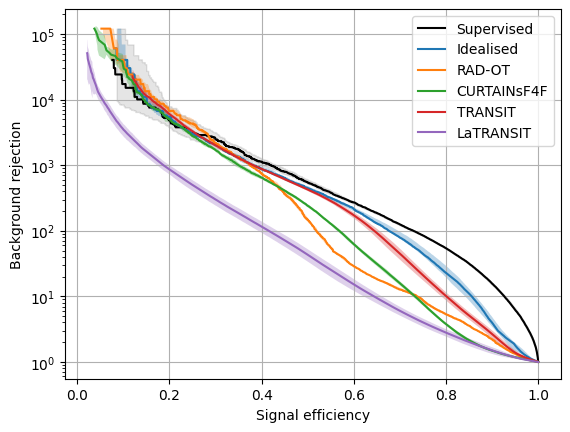

In [43]:
plt.figure()
plt.plot(supervised_curve["x"], supervised_curve["y_center"], label="Supervised", color="black")
plt.fill_between(supervised_curve["x"], supervised_curve["y_down"], supervised_curve["y_up"], alpha=0.1, color="black")
plt.plot(idealised_curve["x"], idealised_curve["y_center"], label="Idealised")
plt.fill_between(idealised_curve["x"], idealised_curve["y_down"], idealised_curve["y_up"], alpha=0.3)
plt.plot(RADOT_curve["x"], RADOT_curve["y_center"], label="RAD-OT")
plt.fill_between(RADOT_curve["x"], RADOT_curve["y_down"], RADOT_curve["y_up"], alpha=0.3)
plt.plot(curtains_rej[0], curtains_rej[1], label="CURTAINsF4F")
plt.fill_between(curtains_rej[0], curtains_rej[1]-curtains_rej[2], curtains_rej[1]+curtains_rej[2], alpha=0.3)
plt.plot(my_curver_rej[0], my_curver_rej[1], label="TRANSIT")
plt.fill_between(my_curver_rej[0], my_curver_rej[1]-my_curver_rej[2], my_curver_rej[1]+my_curver_rej[2], alpha=0.3)
if add_latent:
    plt.plot(laTRANSIT_curver_rej[0], laTRANSIT_curver_rej[1], label="LaTRANSIT")
    plt.fill_between(laTRANSIT_curver_rej[0], laTRANSIT_curver_rej[1]-laTRANSIT_curver_rej[2], laTRANSIT_curver_rej[1]+laTRANSIT_curver_rej[2], alpha=0.3)
plt.yscale("log")
plt.grid()
plt.legend()
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")
plt.savefig(save_folder+"inverse_rej.png", dpi=300, bbox_inches='tight')

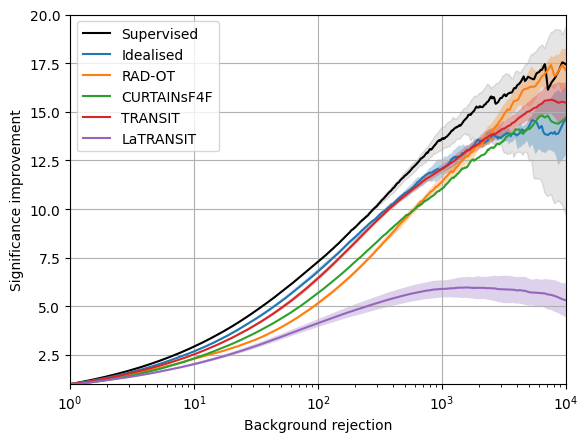

In [44]:
plt.figure()
plt.plot(super_sic["x"], super_sic["y_center"], label="Supervised", color="black")
plt.fill_between(super_sic["x"], super_sic["y_down"], super_sic["y_up"], alpha=0.1, color="black")
plt.plot(ideal_sic["x"], ideal_sic["y_center"], label="Idealised")
plt.fill_between(ideal_sic["x"], ideal_sic["y_down"], ideal_sic["y_up"], alpha=0.3)
plt.plot(radot2["rejection"], radot2["tpr_center"], label="RAD-OT")
plt.fill_between(radot2["rejection"], radot2["tpr_down"], radot2["tpr_up"], alpha=0.3)
plt.plot(curtains_sic[0], curtains_sic[1], label="CURTAINsF4F")
plt.fill_between(curtains_sic[0], curtains_sic[1]-0, curtains_sic[1]+0, alpha=0.3)
plt.plot(my_curve_sic[0], my_curve_sic[1], label="TRANSIT")
plt.fill_between(my_curve_sic[0], my_curve_sic[1]-my_curve_sic[2], my_curve_sic[1]+my_curve_sic[2], alpha=0.3)
if add_latent:
    plt.plot(laTRANSIT_curve_sic[0], laTRANSIT_curve_sic[1], label="LaTRANSIT")
    plt.fill_between(laTRANSIT_curve_sic[0], laTRANSIT_curve_sic[1]-laTRANSIT_curve_sic[2], laTRANSIT_curve_sic[1]+laTRANSIT_curve_sic[2], alpha=0.3)
plt.xscale("log")
plt.xlim(1, 10000)
plt.ylim(1, 20)
plt.xlabel("Background rejection")
plt.ylabel("Significance improvement")
plt.grid()
plt.legend()
plt.savefig(save_folder+"SIC.png", dpi=300, bbox_inches='tight')


## Plot the SI vs Rejection curves

In [45]:
folder = doping_run
dopings = [50, 100, 333, 500, 667, 1000, 3000]
save_suffix=""

In [46]:
SI_vs_rejinv_curves = []

In [47]:
n_dope_per_run=[0, 50, 100, 333, 500, 667, 1000, 3000]
runs = [0, 1, 2, 4, 5, 6, 7, 8]
def getSI_vs_doping_CURTAINS(target_inv_rej):
    # plt.figure()
    SIs =[]
    SI_stds = []
    for run, doping in zip(runs, n_dope_per_run):
        SI_rejs = []
        for seed in range(5):
            SI_curve_file = f"/home/users/o/oleksiyu/WORK/hyperproject/lit/curtains/run_{run}/seed_{seed}/SI_v_rej.npy"
            SI_rej = np.load(SI_curve_file)
            SI_rej[0] = np.flip(SI_rej[0])
            SI_rej[1] = np.flip(SI_rej[1])
            SI_rejs += [SI_rej]
        y, y_std = get_y_and_std_curves(SI_rejs, target_inv_rej)
        SIs += [y]
        SI_stds += [y_std]
    return SIs, SI_stds

In [48]:
# get curves for curtains
n_dope_per_run=[0, 50, 100, 333, 500, 667, 1000, 3000]

SIs_CURTAINS_100 = []
SIs_CURTAINS_1000 = []

def getSI_vs_doping_RADOT(target_inv_rej, mode="standard"):
    # plt.figure()
    SIs =[]
    SI_stds = []
    for run, doping in zip(runs, n_dope_per_run):
        SI_rejs = []
        for seed in range(5):
            SI_curve_file = f"/home/users/o/oleksiyu/WORK/hyperproject/lit/radot/dope_{doping}/{mode}/seed_{seed}/SI_v_rej.npy"
            SI_rej = np.load(SI_curve_file)
            SI_rej[0] = np.flip(SI_rej[0])
            SI_rej[1] = np.flip(SI_rej[1])
            SI_rejs += [SI_rej]
            #plt.plot(SI_rej[0], SI_rej[1], label=f"{doping}")
        y, y_std = get_y_and_std_curves(SI_rejs, target_inv_rej)
        SIs += [y]
        SI_stds += [y_std]
    # plt.grid()
    # plt.ylabel("SI")
    # plt.xlabel("1/Rejection rate")
    # plt.axvline(100, color='black')
    # plt.xscale('log')
    # plt.legend()
    return SIs, SI_stds



SIs_RADOT_100, SIs_RADOT_100_err = getSI_vs_doping_RADOT(100, mode = "supervised")
SI_vs_rejinv_curves += [{"tags": ["invrej_100"],
                         "label": "Supervised",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_100),
                         "y_err": np.array(SIs_RADOT_100_err),
                         "color": "black"}]
SIs_RADOT_1000, SIs_RADOT_1000_err = getSI_vs_doping_RADOT(1000, mode = "supervised")
SI_vs_rejinv_curves += [{"tags": ["invrej_1000"],
                         "label": "Supervised",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_1000),
                         "y_err": np.array(SIs_RADOT_1000_err),
                         "color": "black"}]

SIs_RADOT_100, SIs_RADOT_100_err = getSI_vs_doping_RADOT(100, mode = "idealised")
SI_vs_rejinv_curves += [{"tags": ["invrej_100"],
                         "label": "Idealised",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_100),
                         "y_err": np.array(SIs_RADOT_100_err)}]
SIs_RADOT_1000, SIs_RADOT_1000_err = getSI_vs_doping_RADOT(1000, mode = "idealised")
SI_vs_rejinv_curves += [{"tags": ["invrej_1000"],
                         "label": "Idealised",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_1000),
                         "y_err": np.array(SIs_RADOT_1000_err)}]

SIs_RADOT_100, SIs_RADOT_100_err = getSI_vs_doping_RADOT(100, mode = "standard")
SI_vs_rejinv_curves += [{"tags": ["invrej_100"],
                         "label": "RAD-OT",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_100),
                         "y_err": np.array(SIs_RADOT_100_err)}]
SIs_RADOT_1000, SIs_RADOT_1000_err = getSI_vs_doping_RADOT(1000, mode = "standard")
SI_vs_rejinv_curves += [{"tags": ["invrej_1000"],
                         "label": "RAD-OT",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_1000),
                         "y_err": np.array(SIs_RADOT_1000_err)}]

SIs_RADOT_100, SIs_RADOT_100_err = getSI_vs_doping_CURTAINS(100)
SI_vs_rejinv_curves += [{"tags": ["invrej_100"],
                         "label": "CURTAINsF4F",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_100),
                         "y_err": np.array(SIs_RADOT_100_err)}]
SIs_RADOT_1000, SIs_RADOT_1000_err = getSI_vs_doping_CURTAINS(1000)
SI_vs_rejinv_curves += [{"tags": ["invrej_1000"],
                         "label": "CURTAINsF4F",
                         "x": np.array(n_dope_per_run),
                         "y": np.array(SIs_RADOT_1000),
                         "y_err": np.array(SIs_RADOT_1000_err)}]

In [49]:
def getSI_vs_doping_curve_TRANSIT(target_inv_rej, latent=""):
    SIs = []
    SI_errs = []
    for doping in dopings:
        SI_curve_file = f"{folder}/run-doping_{doping}/plots/compare/TwinTurbo{latent}_SI_v_rej_comb_seeds_CWOLA.npy"
        SI_rej = np.load(SI_curve_file)
        rej_inv = SI_rej[0]
        SI = SI_rej[1]
        SI_err = SI_rej[2]
        #plt.plot(rej_inv, SI, marker='o', label=f"{doping}")
        SIs.append(linear_interpolation(rej_inv, SI, target_inv_rej))
        SI_errs.append(linear_interpolation(rej_inv, SI_err, target_inv_rej))
    return np.array(SIs), np.array(SI_errs)

In [50]:
SIs, SI_errs = getSI_vs_doping_curve_TRANSIT(100)
SI_vs_rejinv_curves += [{"tags": ["invrej_100"],
                         "label": "TRANSIT",
                         "x": np.array(dopings),
                         "y": SIs,
                         "y_err": SI_errs}]
if add_latent:
    SIs, SI_errs = getSI_vs_doping_curve_TRANSIT(100, latent="Latent")
    SI_vs_rejinv_curves += [{"tags": ["invrej_100"],
                            "label": "LaTRANSIT",
                            "x": np.array(dopings),
                            "y": SIs,
                            "y_err": SI_errs}]

In [51]:
SIs, SI_errs = getSI_vs_doping_curve_TRANSIT(1000)
SI_vs_rejinv_curves += [{"tags": ["invrej_1000"],
                         "label": "TRANSIT",
                         "x": dopings,
                         "y": SIs,
                         "y_err": SI_errs}]
if add_latent:
    SIs, SI_errs = getSI_vs_doping_curve_TRANSIT(1000, latent="Latent")
    SI_vs_rejinv_curves += [{"tags": ["invrej_1000"],
                            "label": "LaTRANSIT",
                            "x": dopings,
                            "y": SIs,
                            "y_err": SI_errs}]

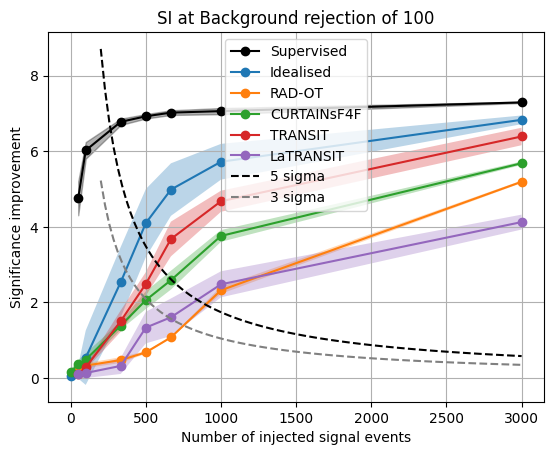

In [52]:
rej_target = 100
curve_order = ["Supervised", "Idealised", "CURTAINsF4F", "RAD-OT", "TRANSIT"]
for curve in SI_vs_rejinv_curves:
    if f"invrej_{rej_target}" in curve["tags"]:
        #print(curve)
        plt.plot(curve["x"], curve["y"], marker='o', label=curve["label"], color = curve.get("color", None))
        if curve.get("color", None) is not None:
            plt.fill_between(curve["x"], curve["y"]-curve["y_err"], curve["y"]+curve["y_err"], alpha=0.3, color = curve["color"])
        else:
            plt.fill_between(curve["x"], curve["y"]-curve["y_err"], curve["y"]+curve["y_err"], alpha=0.3)
plt.grid()
n_dope_per_run_plot = np.linspace(200, 3000, 100)
plt.plot(n_dope_per_run_plot, 5/(n_dope_per_run_plot/np.sqrt(N_EVENTS_SR)), color="black", label="5 sigma", linestyle="--")
n_dope_per_run_plot = np.linspace(200, 3000, 100)
plt.plot(n_dope_per_run_plot, 3/(n_dope_per_run_plot/np.sqrt(N_EVENTS_SR)), color="gray", label="3 sigma", linestyle="--")
plt.ylabel("Significance improvement")
plt.xlabel("Number of injected signal events")
plt.title(f"SI at Background rejection of {rej_target}")
plt.legend()
plt.savefig(save_folder+f"SI_vs_doping_{rej_target}{save_suffix}.png", dpi=300, bbox_inches='tight')

{'tags': ['invrej_1000'], 'label': 'Supervised', 'x': array([   0,   50,  100,  333,  500,  667, 1000, 3000]), 'y': array([        nan,  4.45216643,  9.99517426,  9.40730374, 12.66804366,
       12.19796346, 11.48285221, 13.24014109]), 'y_err': array([       nan, 0.77761548, 1.65325205, 4.69513488, 0.60850699,
       0.81017387, 0.76856844, 0.46258479]), 'color': 'black'}
{'tags': ['invrej_1000'], 'label': 'Idealised', 'x': array([   0,   50,  100,  333,  500,  667, 1000, 3000]), 'y': array([2.25431830e-03, 3.11565959e-02, 6.28092750e-01, 2.96683788e+00,
       5.28009788e+00, 9.67483193e+00, 1.06612386e+01, 1.20742427e+01]), 'y_err': array([0.00258161, 0.04982367, 1.17898287, 1.70254013, 1.41955934,
       1.69670368, 0.97975396, 0.43623101])}
{'tags': ['invrej_1000'], 'label': 'RAD-OT', 'x': array([   0,   50,  100,  333,  500,  667, 1000, 3000]), 'y': array([        nan,  0.        ,  0.07989986,  0.21291145,  0.51562376,
        1.57714592,  3.8372782 , 11.88062544]), 'y_err': arra

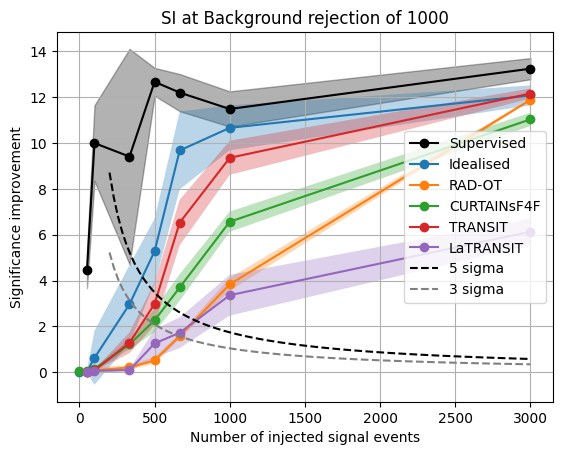

In [53]:

rej_target = 1000
curve_order = ["Supervised", "Idealised", "CURTAINsF4F", "RAD-OT", "TRANSIT"]
for curve in SI_vs_rejinv_curves:
    if f"invrej_{rej_target}" in curve["tags"]:
        print(curve)
        plt.plot(curve["x"], curve["y"], marker='o', label=curve["label"], color = curve.get("color", None))
        if curve.get("color", None) is not None:
            plt.fill_between(curve["x"], curve["y"]-curve["y_err"], curve["y"]+curve["y_err"], alpha=0.3, color = curve["color"])
        else:
            plt.fill_between(curve["x"], curve["y"]-curve["y_err"], curve["y"]+curve["y_err"], alpha=0.3)
plt.grid()
n_dope_per_run_plot = np.linspace(200, 3000, 100)
plt.plot(n_dope_per_run_plot, 5/(n_dope_per_run_plot/np.sqrt(N_EVENTS_SR)), color="black", label="5 sigma", linestyle="--")
n_dope_per_run_plot = np.linspace(200, 3000, 100)
plt.plot(n_dope_per_run_plot, 3/(n_dope_per_run_plot/np.sqrt(N_EVENTS_SR)), color="gray", label="3 sigma", linestyle="--")
plt.ylabel("Significance improvement")
plt.xlabel("Number of injected signal events")
plt.title(f"SI at Background rejection of {rej_target}")
plt.legend()
plt.savefig(save_folder+f"SI_vs_doping_{rej_target}{save_suffix}.png", dpi=300, bbox_inches='tight')
